# Basic Reinforcement Learning
Purpose: To learn about RL from its most basic instantiation.

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from copy import deepcopy

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:6") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

In [2]:
device

device(type='cpu')

In [3]:
import gym

In [15]:
env = gym.make('LunarLander-v2')

In [4]:
env = gym.make('CartPole-v0')

# Agent

In [466]:
class Vector_env(gym.Wrapper):
    '''
     class Vector_env
     
     Acts as a wrapper for the OpenAI gym environments.
    '''
    def __init__(self, env, n=1):
        '''
         venv = Vector_env(env, n=1)
         
         Creates n copies of env.
        '''
        super().__init__(env)
        self.envs = []
        self.n_envs = n
        for k in range(n):
            env_r = deepcopy(env)
            env_r.seed(np.random.randint(10000))
            self.envs.append(env_r)
    
    def reset(self):
        '''
         states = venv.reset()
         
         Resets all the environments, and returns an array with the
         reset states in each row.
        '''
        states = []
        for e in self.envs:
            state = e.reset()
            states.append(state)
        self.S = np.array(states)
        return np.array(states)
    
    def step(self, actions):
        '''
         S, R, done, info = venv.step(actions)
         
         Takes one step in each of the environments, and returns an array
         for each of the resulting outputs.
         
         Inputs:
           actions   an array of actions
           
         Outputs:
           S    array of states after the step
           R    array of rewards from the step
           done array of Boolean flags:
                  False means episode continues
                  True means episode is done
        '''
        S, R, dones = [], [], []
        for e,a in zip(self.envs, actions):
            next_s, r, done, inf = e.step(a)
            if done:
                S.append(e.reset())
            else:
                S.append(next_s)
            R.append(r)
            dones.append(done)
        return np.array(S), np.array(R), np.array(dones)
    
    def state(self):
        S = []
        for e in self.envs:
            S.append(e.state)
        return np.array(S)

In [1537]:
class Agent():
    '''
     class Agent
     
     Represents an RL agent. Its Q function is represented by a neural network, so that
       agent.Q(s) returns a vector of probabilities over action-space.
    '''
    def __init__(self, envs):
        '''
         ag = Agent(envs)
         
         Instantiates an Agent object.
         
         Inputs:
           envs  a Vector_env object, containing the environments for the task
        '''
        self.envs = envs
        self.state_dim = self.envs.observation_space.shape[0]  #state_dim
        self.n_actions = self.envs.action_space.n  #n_actions
        #self.state = torch.zeros(self.state_dim)
        self._max_episode_steps = 100
        
        #**** DEBUG ****
        #self.a_pointer = 0
        #***************
        
        # Policy
        self.hidden = 100
        self.Pi_net = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.hidden, self.n_actions)).to(device)
        
        
        # Value function
        self.V_hidden = 80
        self.V_net = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.V_hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.V_hidden, 1)).to(device)
        
        # Eligibility-trace buffer for Pi_net
        self.Piz = []
        for p in self.Pi_net.parameters():
            self.Piz.append(torch.zeros_like(p))
            
        # Eligibility-trace buffer for V_net
        self.Vz = []
        for p in self.V_net.parameters():
            self.Vz.append(torch.zeros_like(p))
        
    def Pi(self, states=None):
        if states is None:
            S = torch.tensor(self.envs.state(), dtype=torch.float, device=device)
        else:
            S = torch.tensor(states, dtype=torch.float, device=device)
        return torch.distributions.Categorical(logits=self.Pi_net(S))
    
    def V(self, states=None):
        if states is None:
            S = torch.from_numpy(self.envs.state()).to(device)
        else:
            S = torch.tensor(states, dtype=torch.float).to(device)
        return self.V_net(S)
    
    
    def ChooseAction(self, state=None, eps=0.):
        '''
         A = ag.ChooseAction(state, eps=0.)
         
         Choose an action, given the state.
         With probability eps, it will choose an action randomly.
         Otherwise, it will choose an action that yields the highest Q-value.
        '''
        #self.a_pointer += 1
        #return global_A[self.a_pointer-1,:]
    
        if state is None:
            state = self.envs.state()
            
        batchsize = len(state)
        
        with torch.no_grad():
            Pa = self.Pi(state)
        A = Pa.sample().detach().cpu().numpy()
        
        # With prob eps, choose random action
        #A_random = np.array(np.random.randint(0, high=self.n_actions, size=batchsize), dtype=np.float)
        A_random = np.random.choice(self.n_actions, batchsize)
        r = np.random.rand(batchsize)
        ridx = r<eps
        A[ridx] = A_random[ridx]
        
        return A
  
    def Episode(self, T=200, gamma=1., eps=0.):
        '''
         traj = ag.Episode(gamma=1.)
         
         Runs one episode, and returns the trajectory. The environment is
         automatically reset at the beginning of the episode.
                 
         Inputs:
           T      number of action steps
           gamma  reward discount
         
         Outputs:
           traj trajectory, as a list of lists of the form
                [A, S, Snext, R, G, done, info]
                A     action taken at state S
                S     state
                Snext state after taking action A
                R     reward
                G     future return (discounted)
                done  flag to indicate episode is done
                info  not sure ?
        '''
        #S = self.envs.reset()
        S = self.envs.S
        traj = []
        bs = len(S)  # batchsize
        for k in range(T):
            action = self.ChooseAction(state=S, eps=eps)
            Snext, r, done = self.envs.step(action)
            traj.append(dict(action=action, S=S, Snext=Snext, r=r, G=np.zeros(bs), done=done))
            S = Snext
            if False: #done.all():
                break
                
        self.envs.S = S
        # Use that trajectory (and rewards) to update the policy parameters
        # Process the return for all visited states
        traj[-1]['G'] = traj[-1]['r']
        for k in range(len(traj)-2, -1, -1):
            traj[k]['G'] = traj[k]['r'] + (1.-traj[k]['done'])*gamma*traj[k+1]['G']
        return traj
    
    def ComputeReturns(self, R, dones, gamma=1.):
        G = np.zeros_like(R)
        G[-1] = R[-1]
        for k in range(len(R)-2, -1, -1):
            G[k] = R[k] + (1.-dones[k])*G[k+1]
        return G

    def Simulate(self, trials=1, eps=0.):
        time.sleep(1)
        avg_k = 0.
        for trial in range(trials):
            observation = self.envs.envs[0].reset()
            for k in range(self._max_episode_steps):
                self.envs.envs[0].render()
                action = self.ChooseAction(state=[observation], eps=eps)

                observation, reward, done, info = self.envs.envs[0].step(action[0])

                if done:
                    print('Done after '+str(k))
                    avg_k += k
                    break
        print('Average reward: '+str(avg_k/trials))
        time.sleep(1)
        self.envs.envs[0].close()
        
        
    
    def orig_REINFORCE_baseline(self, T=200, gamma=1.0, alpha=0.0001, alpha_v=0.0001, eps=0.1):
        # Perform an episode and record the trajectory
        traj = self.Episode(T=T, eps=eps(0))
        bs = len(traj[0]['action'])
                
        # Update policy parameters
        gamma_t = torch.tensor(gamma).to(device)
        Pa_loss = torch.tensor(0.).to(device)
        V_loss = torch.tensor(0.).to(device)
        
        Gmax = np.zeros(bs, dtype=float)
        Gbest = traj[0]['G']
        Ghist = []
        
        for k,blah in enumerate(traj):
            A = torch.from_numpy(blah['action']).to(device)
            S = blah['S']
            G = torch.from_numpy(blah['G']).float().to(device)  # future return
            G.requires_grad = False
            dones = blah['done']
            
            Gmax = np.maximum(Gmax, blah['G'])
            Ghist.append(blah['G'])
            
            # Policy network
            Pa = self.Pi(S)  # returns a distribution object
            
            # Value network
            V = self.V(S).squeeze()
            
            # Error
            with torch.no_grad():
                err = G - V
            
            # Recall that d(log(Pi)) = dPi / Pi
            logPa_x_err = Pa.log_prob(A) * err  # * gamma_t
            Pa_loss = Pa_loss + torch.mean(logPa_x_err)
            V_loss = V_loss + torch.mean( (G-V)**2 ) * gamma_t
            
            gamma_t = gamma_t*gamma
        
        # Backproject gradient
        self.Pi_net.zero_grad()
        self.V_net.zero_grad()
        Pa_loss.backward()
        V_loss.backward()
        with torch.no_grad():
            #print(self.Pi_net[-1].weight.grad)
            for p in self.Pi_net.parameters():
                #print(torch.sum(p.grad**2))
                p += alpha * p.grad
            for p in self.V_net.parameters():
                #print(torch.sum(p.grad**2))
                p -= alpha_v * p.grad
            
        #return traj
        #return torch.mean( torch.max(G, dim=0)[0] ).cpu().item()
        return Gmax
        #return np.array(Ghist)


    def REINFORCE_baseline(self, T=200, gamma=1.0, alpha=0.0001, alpha_v=0.0001, eps=0.1):
        
        # Run and record a batch of rollouts
        states = np.empty((T, self.envs.n_envs, self.state_dim))
        actions = np.empty((T, self.envs.n_envs))
        rewards = np.empty((T, self.envs.n_envs))
        dones = np.empty((T, self.envs.n_envs))
        #S = self.envs.reset()
        S = self.envs.S
        for t in range(T):
            A = self.ChooseAction(state=S, eps=eps(t))
            Snext, r, done = self.envs.step(A)
            states[t] = S
            actions[t] = A
            rewards[t] = r
            dones[t] = done
            S = Snext
            
        self.envs.S = S
        
        A = torch.from_numpy(actions).to(device)
        
        # Calculate returns
        G = self.ComputeReturns(rewards, dones, gamma=gamma)
        G = torch.from_numpy(G).to(device)
        G.requires_grad = False
        
        # Run the policy network and value network on the rollout
        Pa = self.Pi(states)
        V = self.V(states).squeeze()
        
        # Calculate error
        with torch.no_grad():
            delta = G - V

        # Policy loss
        logPa_x_err = torch.mean(Pa.log_prob(A) * delta, dim=1)
        Pa_loss = torch.sum( logPa_x_err )
        
        # Critic loss
        V_loss = torch.sum( torch.mean((G-V)**2, dim=1) )        
        
        # Backproject gradient
        self.Pi_net.zero_grad()
        self.V_net.zero_grad()
        Pa_loss.backward()
        V_loss.backward()
        
        # Gradient step
        with torch.no_grad():
            #print(self.Pi_net[-1].weight.grad)
            for p in self.Pi_net.parameters():
                #print(torch.sum(p.grad**2))
                p += alpha * p.grad
            for p in self.V_net.parameters():
                #print(torch.sum(p.grad**2))
                p -= alpha_v * p.grad

        return torch.max(G, dim=0)[0].cpu().numpy()
        #return G.cpu().numpy()

### Cart-Pole

In [1546]:
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
S = env.reset()
T = 200
envs = Vector_env(env, n=32)
global_A = np.random.choice(2, (2*T,len(envs.envs)))
ag = Agent(envs)
ag.envs.reset()
ag0 = deepcopy(ag)
ag1 = deepcopy(ag)

In [1547]:
score = []
counter = 0

In [1548]:
interval = 10
iters = 1000

In [1541]:
mysum = 0.
for i_episode in range(iters):
    Gmax = ag0.orig_REINFORCE_baseline(T=T, alpha=0.0001, alpha_v=0.0001, eps=(lambda x: 0.))
    counter += 1
    mysum += np.mean(Gmax)
    if counter%interval==0:
        print(f'{counter}: {mysum/interval}')
        score.append(mysum/interval)
        mysum = 0.

10: 44.425
20: 47.71875
30: 50.6
40: 50.671875
50: 54.496875
60: 55.70625
70: 57.61875
80: 59.2875
90: 59.990625
100: 64.8625


In [1549]:
mysum = 0.
for i_episode in range(iters):
    Gmax = ag1.REINFORCE_baseline(T=T, alpha=0.0001, alpha_v=0.0001, eps=(lambda x: 0.))
    counter += 1
    mysum += np.mean(Gmax)
    if counter%interval==0:
        print(f'{counter}: {mysum/interval}')
        score.append(mysum/interval)
        mysum = 0.

10: 45.975
20: 48.603125
30: 51.953125
40: 54.45625
50: 56.25625
60: 61.425
70: 61.51875
80: 62.996875
90: 61.346875
100: 63.50625
110: 64.95625
120: 67.834375
130: 68.128125
140: 71.34375
150: 73.9625
160: 69.48125
170: 73.45
180: 72.7125
190: 72.046875
200: 76.1
210: 77.94375
220: 81.06875
230: 77.296875
240: 80.75
250: 87.315625
260: 83.640625
270: 83.76875
280: 82.9
290: 86.5625
300: 88.628125
310: 85.98125
320: 89.546875
330: 88.715625
340: 84.221875
350: 91.040625
360: 85.3125
370: 88.50625
380: 92.50625
390: 90.615625
400: 89.715625
410: 95.090625
420: 96.115625
430: 105.415625
440: 106.921875
450: 98.20625
460: 97.51875
470: 110.83125
480: 114.078125
490: 118.559375
500: 115.371875
510: 109.025
520: 132.021875
530: 124.040625
540: 135.225
550: 130.5
560: 124.46875
570: 137.765625
580: 138.071875
590: 140.990625
600: 139.534375
610: 145.98125
620: 146.45
630: 146.890625
640: 145.384375
650: 144.546875
660: 144.625
670: 143.521875
680: 140.34375
690: 147.73125
700: 144.696875
710

In [ ]:
ag0.Pi(ag0.envs.S).probs

In [ ]:
ag1.Pi(ag1.envs.S).probs

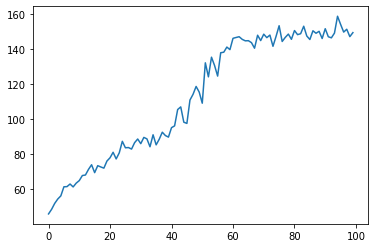

In [1550]:
plt.plot(score);

In [1551]:
ag_r.Simulate(3, eps=0.)

Done after 123
Done after 133
Done after 199
Average reward: 151.66666666666666


In [32]:
ag_r.envs.envs[0].close()

## REINFORCE with Baseline

In [61]:
env = gym.make('CartPole-v0')

S = env.reset()
ag_rb = Agent(env)
ag_rb.env._max_episode_steps = 500

In [62]:
score2 = []
counter = 0
mysum = 0
interval = 50

In [76]:
for i_episode in range(200):
    traj = traj = ag_rb.REINFORCE_baseline(alpha=0.0001, alpha_v=0.0001)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score2.append(mysum/interval)
        mysum = 0

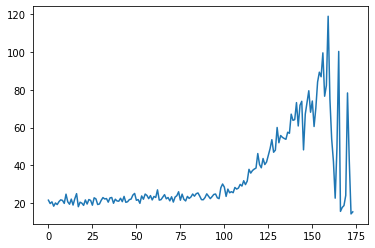

In [77]:
plt.plot(score2);

In [75]:
S = ag_rb.env.reset()
print(S)
ag_rb.V(torch.tensor(S, dtype=torch.float))

[-0.0245504   0.0344018  -0.00279386  0.02541287]


tensor([1.8533], grad_fn=<AddBackward0>)

In [63]:
ag_rb.V(torch.tensor([0, 0, 0, 0], dtype=torch.float))

tensor([17.9258], grad_fn=<AddBackward0>)